In [ ]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import shutil
from sklearn.model_selection import train_test_split
from transformers import AutoProcessor, AutoModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from transformers import AutoModel, AutoProcessor, CLIPModel, CLIPProcessor
from collections import Counter

e:\repos\CLIP_multimodal_search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Этап 1. Fine-tuning CLIP

### 1. Работа с данными

In [2]:
class FashionDataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image']
        description = self.data.iloc[idx]['description']
        
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, description

In [3]:
dataset = FashionDataset(
    csv_file='archive/data.csv',
    images_dir='archive/data',
    transform=transforms.ToTensor()
)

#### Несколько картинок из датасета с описаниями

Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only


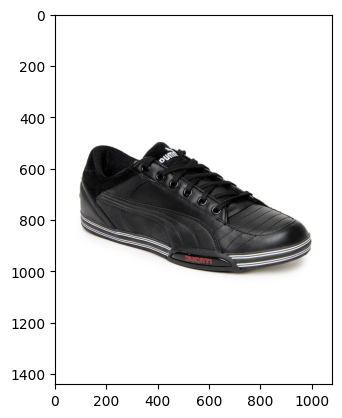

In [4]:
image, label = dataset.__getitem__(0)
plt.imshow(image.permute(1, 2, 0))
print(label)

Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water using a mild detergent Do not bleach Tumble dry low Cool iron; do not iron on decorations Size and fit Regular fit


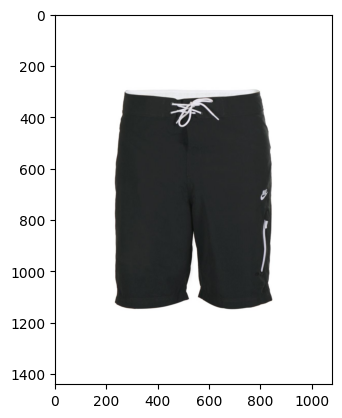

In [5]:
image, label = dataset.__getitem__(1)
plt.imshow(image.permute(1, 2, 0))
print(label)

Teal  handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket  and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back


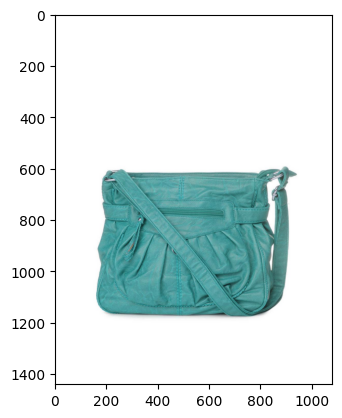

In [6]:
image, label = dataset.__getitem__(2)
plt.imshow(image.permute(1, 2, 0))
print(label)

#### Разрешение картинок

In [7]:
image.size()

torch.Size([3, 1440, 1080])

In [ ]:
def save_cleaned_dataset(df, split_name, output_dir, images_dir):
    split_dir = os.path.join(output_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'data'), exist_ok=True)
    
    for _, row in df.iterrows():
        src_path = os.path.join(images_dir, row['image'])
        dst_path = os.path.join(split_dir, 'data', row['image'])
        shutil.copy2(src_path, dst_path)
    
    df.to_csv(os.path.join(split_dir, f'{split_name}.csv'), index=False)


def preprocess_data(csv_file, images_dir, output_dir='cleaned_data'):
    # Создаем директорию для очищенных данных
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    
    # Загружаем данные
    df = pd.read_csv(csv_file)
    
    print(f"Исходный размер датасета: {len(df)}")
    
    # Удаляем строки с пустыми значениями
    df_cleaned = df.dropna(subset=['image', 'description'])
    print(f"После удаления пустых значений: {len(df_cleaned)}")
    
    # Удаляем дубликаты по названию изображения
    df_cleaned = df_cleaned.drop_duplicates(subset=['image'])
    print(f"После удаления дубликатов по изображению: {len(df_cleaned)}")
    
    # Удаляем дубликаты по описанию
    df_cleaned = df_cleaned.drop_duplicates(subset=['description'])
    print(f"После удаления дубликатов по описанию: {len(df_cleaned)}")
    
    # Проверяем существование файлов изображений
    valid_rows = []
    missing_images = []
    
    for idx, row in df_cleaned.iterrows():
        img_path = os.path.join(images_dir, row['image'])
        if os.path.exists(img_path):
            valid_rows.append(row)
        else:
            missing_images.append(row['image'])
    
    df_final = pd.DataFrame(valid_rows)
    print(f"После проверки существования изображений: {len(df_final)}")
    print(f"Отсутствующие изображения: {len(missing_images)}")
    
    train_df, test_df = train_test_split(
        df_final, 
        test_size=0.1, 
        random_state=42,
        shuffle=True
    )
    
    print(f"Train размер: {len(train_df)}")
    print(f"Test размер: {len(test_df)}")
    
    save_cleaned_dataset(train_df, 'train', output_dir, images_dir)
    save_cleaned_dataset(test_df, 'test', output_dir, images_dir)
    
    # Сохраняем общий очищенный датасет
    df_final.to_csv(os.path.join(output_dir, 'cleaned_data.csv'), index=False)
    
    return train_df, test_df

# Запускаем предобработку
train_df, test_df = preprocess_data('archive/data.csv', 'archive/data')

Исходный размер датасета: 44441
После удаления пустых значений: 44160
После удаления дубликатов по изображению: 44160
После удаления дубликатов по описанию: 38856
После проверки существования изображений: 38856
Отсутствующие изображения: 0
Train размер: 36913
Test размер: 1943


In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = FashionDataset(
    csv_file='cleaned_data/train/data.csv',
    images_dir='cleaned_data/train/data',
    transform=transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
)

test_dataset = FashionDataset(
    csv_file='cleaned_data/test/data.csv',
    images_dir='cleaned_data/test/data',
    transform=transform
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
)

### 2. Работа с моделью

In [11]:
model_name = "openai/clip-vit-base-patch32"
model = AutoModel.from_pretrained(model_name).to('cuda')
processor = AutoProcessor.from_pretrained(model_name)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
images, texts = next(iter(test_dataloader))

In [13]:
texts

('Style Note With its classic styling this shirt from myntra is a piece that will easily slot into your daily wear wardrobe. Made of pure cotton this shirt lets you stay comfortable even on sunny days. Pair it with formal trousers and polished derby shoes for a look that exudes complete control and confidence. Product Details Green and white striped shirt, spread collar, long sleeves with buttoned cuffs, patch pocket on the left chest, full buttoned placket, cross grain yoke at back and a curved hem Material and Care 100% cotton Machine wash cold Warm iron Size and Fit Regular fit The model (height 6\' and shoulders 18") is wearing a size M',
 'Pear shaped base with green and blue colour patterns A wide pear shaped dangler with intricate coloured patterns Has bead drops from the base of the dangler Post and back closure',
 'Look great in this 100% polyester, sweat absorbing t-shirt and feel dry all day!   ',
 'Black sleeveless dress with a round neck, gathers at the front, yoke at the 

In [14]:
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True).to(model.device)

with torch.no_grad():
    outputs = model(**inputs)
    clip_logit_score = outputs.logits_per_image

print("CLIP logit score:", clip_logit_score)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


CLIP logit score: tensor([[18.0006, 15.5676, 19.3203, 25.9794, 18.2035, 18.9008, 17.3662, 20.2734],
        [18.2710, 15.3856, 19.6103, 25.7594, 18.3068, 18.9705, 17.5999, 20.2091],
        [18.3701, 15.5417, 19.6108, 25.9764, 18.3796, 19.0527, 17.6190, 20.4279],
        [18.6475, 15.6416, 19.7964, 26.0309, 18.5431, 19.1742, 17.7932, 20.5699],
        [18.2380, 15.4694, 19.4391, 25.9802, 18.5243, 18.9962, 17.4584, 20.3052],
        [18.5340, 15.8169, 19.6274, 25.9783, 18.4505, 19.1142, 17.7463, 20.6477],
        [18.3354, 15.4604, 19.6093, 25.9303, 18.6033, 19.0871, 17.6626, 20.3125],
        [18.5062, 15.5843, 19.6645, 26.0714, 18.5056, 19.0898, 17.6866, 20.4806]],
       device='cuda:0')


In [17]:
del model
del processor

### 3. Дообучение

In [ ]:
class Config:
    batch_size = 32
    learning_rate = 5e-5
    num_epochs = 4
    log_interval = 50
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = "openai/clip-vit-base-patch32"
    save_dir = "checkpoints"
    max_length = 77


class FashionCLIP(nn.Module):
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        super(FashionCLIP, self).__init__()
        self.model = CLIPModel.from_pretrained(model_name)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        
        # Замораживаем базовые слои
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Размораживаем последние слои для дообучения
        # Vision Transformer - последние слои
        for param in self.model.vision_model.encoder.layers[-2:].parameters():
            param.requires_grad = True
            
        # Text Transformer - последние слои  
        for param in self.model.text_model.encoder.layers[-2:].parameters():
            param.requires_grad = True
            
        # Проекционные слои
        for param in self.model.visual_projection.parameters():
            param.requires_grad = True
        for param in self.model.text_projection.parameters():
            param.requires_grad = True
            
    def forward(self, images, input_ids, attention_mask):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=images,
            return_loss=False
        )
        return outputs.image_embeds, outputs.text_embeds
    
    def encode_image(self, images):
        return self.model.get_image_features(pixel_values=images)
    
    def encode_text(self, input_ids, attention_mask):
        return self.model.get_text_features(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )

def clip_score(logits_per_image, logits_per_text):
    labels = torch.arange(logits_per_image.shape[0]).to(logits_per_image.device)
    
    img_acc = (logits_per_image.argmax(dim=1) == labels).float().mean()
    text_acc = (logits_per_text.argmax(dim=0) == labels).float().mean()
    
    return (img_acc + text_acc) / 2 * 100

def validate(model, val_loader, epoch):
    model.eval()
    total_clip_score = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, texts in tqdm(val_loader, desc=f"Validation Epoch {epoch}"):
            # Подготовка изображений
            images = [image for image in images]  # Convert to list for processor
            processed_images = model.processor(images=images, return_tensors="pt")
            pixel_values = processed_images['pixel_values'].to(Config.device)
            
            # Подготовка текстов
            processed_texts = model.processor(
                text=texts, 
                padding=True, 
                truncation=True,
                max_length=Config.max_length,
                return_tensors="pt"
            )
            input_ids = processed_texts['input_ids'].to(Config.device)
            attention_mask = processed_texts['attention_mask'].to(Config.device)
            
            # Получение эмбеддингов
            image_features, text_features = model(
                pixel_values, input_ids, attention_mask
            )
            
            # Нормализация
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            
            # Вычисление similarity
            logit_scale = model.model.logit_scale.exp()
            logits_per_image = logit_scale * image_features @ text_features.t()
            logits_per_text = logits_per_image.t()
            
            batch_clip_score = clip_score(logits_per_image, logits_per_text)
            total_clip_score += batch_clip_score.item()
            num_batches += 1
    
    avg_clip_score = total_clip_score / num_batches
    return avg_clip_score

def train_clip_model():
    # Инициализация модели
    model = FashionCLIP(Config.model_name).to(Config.device)
    
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(
        trainable_params,
        lr=Config.learning_rate,
        weight_decay=0.1,
        betas=(0.9, 0.98),
        eps=1e-6
    )
    
    # Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=len(train_dataloader) * Config.num_epochs
    )
    
    train_losses = []
    train_scores = []
    val_scores = []

    
    for epoch in range(Config.num_epochs):
        model.train()
        running_loss = 0.0
        running_clip_score = 0.0
        num_batches = 0
        
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{Config.num_epochs}')
        
        for batch_idx, (images, texts) in enumerate(progress_bar):
            # Подготовка данных
            processed_images = model.processor(images=images, return_tensors="pt")
            pixel_values = processed_images['pixel_values'].to(Config.device)
            
            processed_texts = model.processor(
                text=texts, 
                padding=True, 
                truncation=True,
                max_length=Config.max_length,
                return_tensors="pt"
            )
            input_ids = processed_texts['input_ids'].to(Config.device)
            attention_mask = processed_texts['attention_mask'].to(Config.device)
            
            # Forward
            image_features, text_features = model(pixel_values, input_ids, attention_mask)
            
            # Нормализация
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            
            logit_scale = model.model.logit_scale.exp()
            logits_per_image = logit_scale * image_features @ text_features.t()
            logits_per_text = logits_per_image.t()
            
            labels = torch.arange(len(images)).to(Config.device)
            loss_img = nn.CrossEntropyLoss()(logits_per_image, labels)
            loss_txt = nn.CrossEntropyLoss()(logits_per_text, labels)
            loss = (loss_img + loss_txt) / 2
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            scheduler.step()
            
            batch_clip_score = clip_score(logits_per_image, logits_per_text)
            
            running_loss += loss.item()
            running_clip_score += batch_clip_score.item()
            num_batches += 1
            
            # Логирование
            if (batch_idx + 1) % Config.log_interval == 0:
                avg_loss = running_loss / num_batches
                avg_score = running_clip_score / num_batches
                current_lr = scheduler.get_last_lr()[0]
                
                progress_bar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'CLIP Score': f'{avg_score:.2f}%',
                    'LR': f'{current_lr:.2e}'
                })
        
        # Валидация в конце эпохи
        avg_val_score = validate(model, test_dataloader, epoch + 1)
        
        # Сохранение метрик
        epoch_loss = running_loss / num_batches
        epoch_train_score = running_clip_score / num_batches
        
        train_losses.append(epoch_loss)
        train_scores.append(epoch_train_score)
        val_scores.append(avg_val_score)
        
        print(f'\nEpoch {epoch+1} завершена:')
        print(f'Train Loss: {epoch_loss:.4f}')
        print(f'Train CLIP Score: {epoch_train_score:.2f}%')
        print(f'Val CLIP Score: {avg_val_score:.2f}%')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.2e}')
        
        # Сохранение чекпоинта
        checkpoint_path = os.path.join(Config.save_dir, f'clip_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': epoch_loss,
            'train_score': epoch_train_score,
            'val_score': avg_val_score,
        }, checkpoint_path)
    
    return train_losses, train_scores, val_scores, model

In [ ]:
print("Старт обучения")
train_losses, train_scores, val_scores, trained_model = train_clip_model()

final_val_score = val_scores[-1]
print(f"\nФинальный CLIP Score на валидации: {final_val_score:.2f}%")

Старт обучения


Validation Epoch 1: 100%|██████████| 486/486 [13:24<00:00,  1.66s/it]



Epoch 1 завершена:
Train Loss: 0.7074
Train CLIP Score: 71.21%
Val CLIP Score: 84.41%
Learning Rate: 4.27e-05


Validation Epoch 2: 100%|██████████| 486/486 [13:40<00:00,  1.69s/it]



Epoch 2 завершена:
Train Loss: 0.3254
Train CLIP Score: 87.05%
Val CLIP Score: 88.14%
Learning Rate: 2.50e-05


Validation Epoch 3: 100%|██████████| 486/486 [13:07<00:00,  1.62s/it]



Epoch 3 завершена:
Train Loss: 0.2016
Train CLIP Score: 92.07%
Val CLIP Score: 93.51%
Learning Rate: 7.32e-06


Validation Epoch 4: 100%|██████████| 486/486 [13:39<00:00,  1.69s/it]



Epoch 4 завершена:
Train Loss: 0.1309
Train CLIP Score: 94.98%
Val CLIP Score: 94.11%
Learning Rate: 0.00e+00

Финальный CLIP Score на валидации: 94.11%


### Графики

In [52]:
def plot_training_curves(train_losses, train_scores, val_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    
    # CLIP score
    epochs = range(1, len(train_scores) + 1)
    ax2.plot(epochs, train_scores, 'g-', linewidth=2, label='Train CLIP Score')
    ax2.plot(epochs, val_scores, 'r-', linewidth=2, label='Val CLIP Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('CLIP Score (%)')
    ax2.set_title('CLIP Score')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

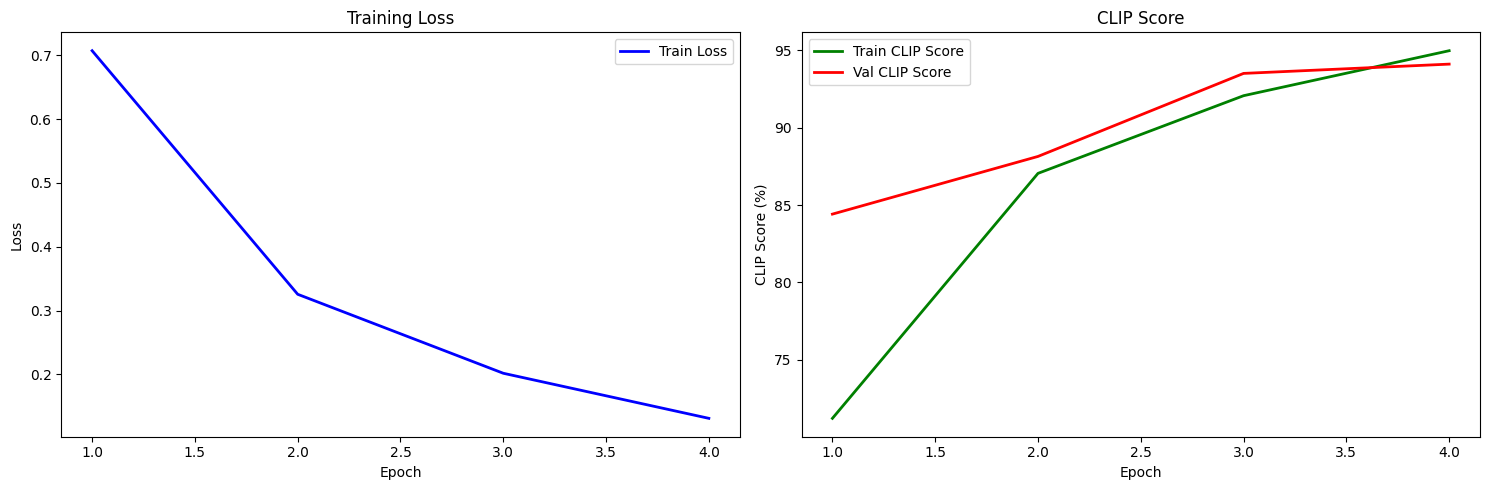

In [53]:
plot_training_curves(train_losses, train_scores, val_scores)

# Этап 2. Реализация системы поиска товаров

In [ ]:
class FashionSearchSystem:
    def __init__(self, checkpoint_path, csv_file, image_dir, device=None):
        self.device = Config.device
        self.image_dir = image_dir
        
        print("Загрузка модели из чекпоинта...")
        self.model = self._load_model_from_checkpoint(checkpoint_path)
        self.model.to(self.device)
        self.model.eval()
        
        print("Загрузка данных...")
        self.data = pd.read_csv(csv_file)
        self.image_paths = [os.path.join(image_dir, img_name) for img_name in self.data['image']]
        self.descriptions = self.data['description'].tolist()

    def _load_model_from_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model = FashionCLIP()
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        return model
    
    def _precompute_image_embeddings(self):
        embeddings = []
        
        for i in tqdm(range(0, len(self.image_paths), Config.batch_size)):
            batch_paths = self.image_paths[i:i + Config.batch_size]
            batch_images = []
            
            # Загрузка и обработка изображений
            for img_path in batch_paths:
                image = Image.open(img_path).convert('RGB')
                batch_images.append(image)
            
            # Обработка через процессор CLIP
            processed_images = self.model.processor(
                images=batch_images, 
                return_tensors="pt"
            )
            pixel_values = processed_images['pixel_values'].to(self.device)
            
            # Получение эмбеддингов
            with torch.no_grad():
                batch_embeddings = self.model.encode_image(pixel_values)
                batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=-1, keepdim=True)
                embeddings.append(batch_embeddings.cpu())
        
        # Объединяем все эмбеддинги
        all_embeddings = torch.cat(embeddings, dim=0)
        return all_embeddings
    
    def save_embeddings(self, save_path):
        torch.save({
            'embeddings': self.image_embeddings,
            'image_paths': self.image_paths,
            'descriptions': self.descriptions,
            'data': self.data
        }, save_path)
        print(f"Эмбеддинги сохранены в {save_path}")
    
    def load_embeddings(self, load_path):
        checkpoint = torch.load(load_path, map_location='cpu', weights_only=False)
        self.image_embeddings = checkpoint['embeddings']
        self.image_paths = checkpoint['image_paths']
        self.descriptions = checkpoint['descriptions']
        self.data = checkpoint['data']
        print(f"Эмбеддинги загружены из {load_path}")
    
    def search_items(self, text_query, top_k=5, return_scores=False):
        with torch.no_grad():
            # Кодируем текстовый запрос
            processed_text = self.model.processor(
                text=[text_query],
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=77
            )
            input_ids = processed_text['input_ids'].to(self.device)
            attention_mask = processed_text['attention_mask'].to(self.device)
            
            text_embedding = self.model.encode_text(input_ids, attention_mask)
            text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
            
            # Вычисляем косинусное сходство
            similarities = (self.image_embeddings.to(self.device) @ text_embedding.T).squeeze()
            
            # Получаем топ-K наиболее релевантных
            top_scores, top_indices = similarities.topk(min(top_k, len(similarities)))
        
        # Формируем результаты
        results = []
        for score, idx in zip(top_scores, top_indices):
            idx = idx.item()
            result = {
                'image_path': self.image_paths[idx],
                'description': self.descriptions[idx],
                'similarity_score': score.item(),
                'index': idx
            }
            results.append(result)
        
        if return_scores:
            return results, similarities.cpu().numpy()
        return results
    
    def display_search_results(self, results, figsize=(15, 10)):
        n_results = len(results)
        n_cols = min(5, n_results)
        n_rows = (n_results + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if n_rows == 1 and n_cols == 1:
            axes = np.array([axes])
        elif n_rows == 1 or n_cols == 1:
            axes = axes.reshape(-1)
        
        for idx, (result, ax) in enumerate(zip(results, axes.flat)):
            image = Image.open(result['image_path'])
            ax.imshow(image)
            ax.set_title(f"Score: {result['similarity_score']:.3f}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()


def initialize_search_system(checkpoint_path, csv_file, image_dir, 
                           embeddings_save_path=None, device=None):
    system = FashionSearchSystem(checkpoint_path, csv_file, image_dir, device)
    
    # Если эмбеддинги сформированы, не формируем заново
    if embeddings_save_path and os.path.exists(embeddings_save_path):
        
        print("Идет загрузка сохраненных эмбеддингов")
        system.load_embeddings(embeddings_save_path)

    elif embeddings_save_path:

        print("Старт формирования эмбеддингов")
        system.image_embeddings = system._precompute_image_embeddings()

        system.save_embeddings(embeddings_save_path)
        print("Эмбеддинги сформированы и сохранены")
    
    return system


Загрузка модели из чекпоинта...
Загрузка данных...
Идет загрузка сохраненных эмбеддингов
Эмбеддинги загружены из precomputed_embeddings.pth

Запрос: 'red skirt'
1. This watch from puma comes in a heavy duty design. The assymentric dial and chunky casing gives this watch a tough appearance perfect for navigating the urban jungle. Dial shape : Rectangle Case diameter : 32 cm Warranty : 2 Years Plastic case with a fixed bezel for added durability, style and comfort Textured rubber straps with a tang clasp for comfort and style Black dial with cat logo on the dial Digital time display Solid case back made of stainless steel for enhanced durability Water resistant upto 100 metres (score: 0.309)
2. Composition Black round neck t-shirt made of 100% cotton with graphic on the front Wash care 1. Light machine wash 2. Do not bleach 3. warm iron on reverse 4. Do not dry clean 5. Dry flat/reverse 6. Do not scrub Fitting Comfort Fit If you are a music lover then you probably believe that God said "

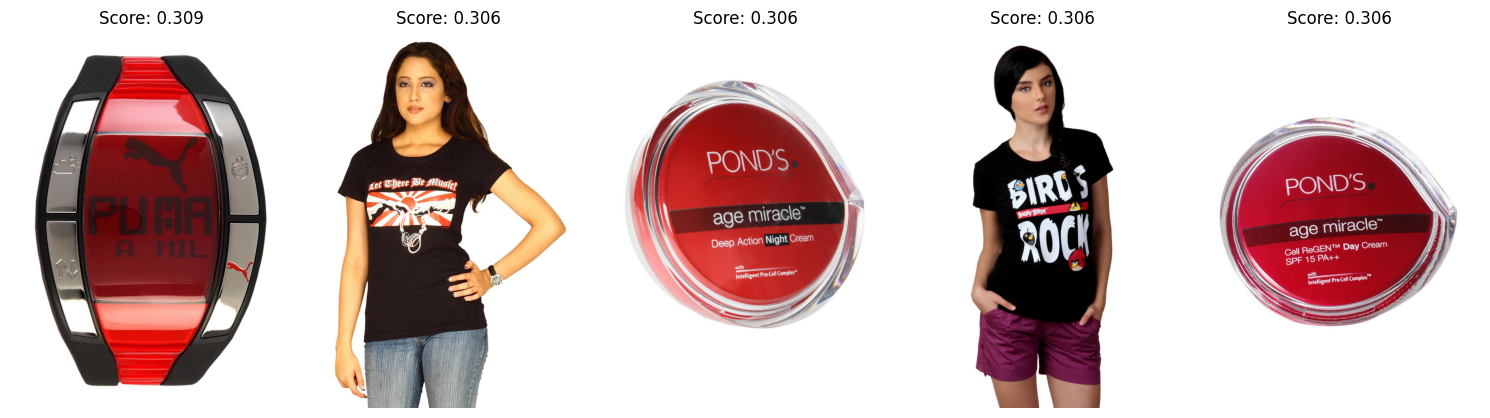


Запрос: 'blue sunglasses'
1. Comfort and style rolled into one - that's playboy for you. Revel in the comfort of flip flops with this stylish pair from Playboy. Upper Rubber thong style straps with rubber toe separator Logo embossed on the straps Foam footbed with printed logo all over Outsole Single piece cushioned rubber footbed and outsole for all-day comfort Brand bunny face logo-styled lugs throughout the footbed for absolute grip and traction on various surfaces Flip flop care Wipe surface with a damp, clean cloth to remove dust (score: 0.300)
2. Lens colour: Graduated black Lens type: 100% UV 400 protection, rounded rectangular lenses and 100% distortion free Frame colour: Transparent blue Frame type: Full frame with fixed nose holders The glasses come in a signature Fastrack case with a soft cloth to clean your lenses Warranty: 1 year Warranty provided by Brand Owner / Manufacturer (score: 0.299)
3. Lens colour: Brown Lens type: Optical class 1 shatterproof polycarbonate lense

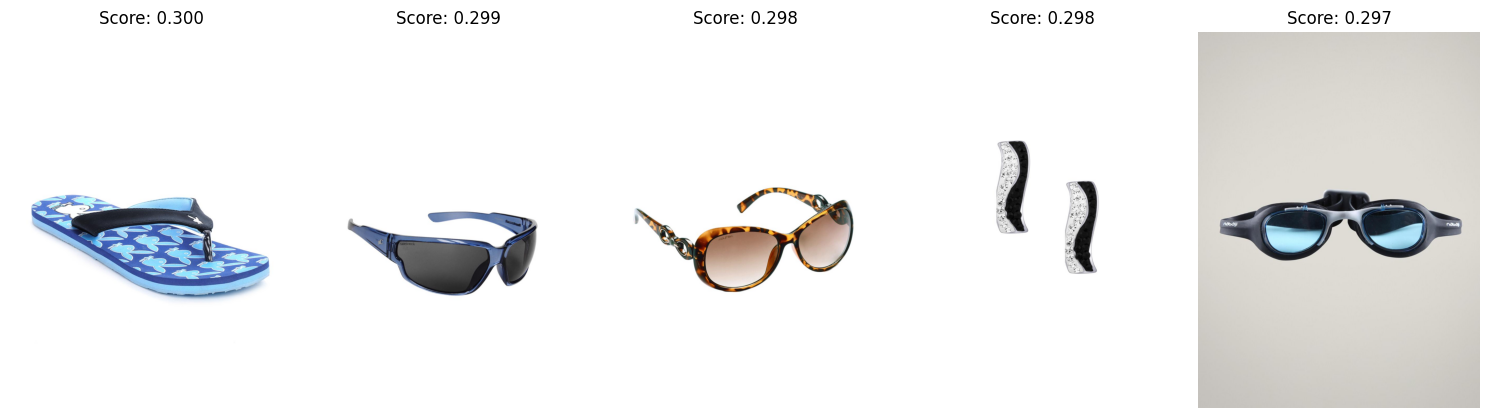


Запрос: 'mickey mouse'
1. Style Note Referencing beach lifestyle, reminiscent of the sun, sand and surf, this pair of shorts from puma is tailored to be worn low on the hips. The print is balanced with a minimal, fuss-free cut. Wear this with a monochrome tee in shades of green or blue. Product Details White printed shorts, has inbuilt mesh briefs, a velcro flap at the elasticated waistband for a good Fit, tie ups at the centre front and a flap pocket with a Velcro closure on the right thigh Material and Care 100% polyester shell and lining Machine wash inside out Do not bleach, tumble dry or dry clean Cool iron inside out Size and Fit Regular Fit The model (height 6' and waist 32")  is wearing a size M (score: 0.314)
2. Composition Bright yellow T-shirt made of 58% cotton and 42% polyester Dri-Fit fabric, has a ribbed round neck with tape detailing on the inseam, short sleeves, graphic print on the front, graphic detailing towards the right hem and brand logo in a reflective material

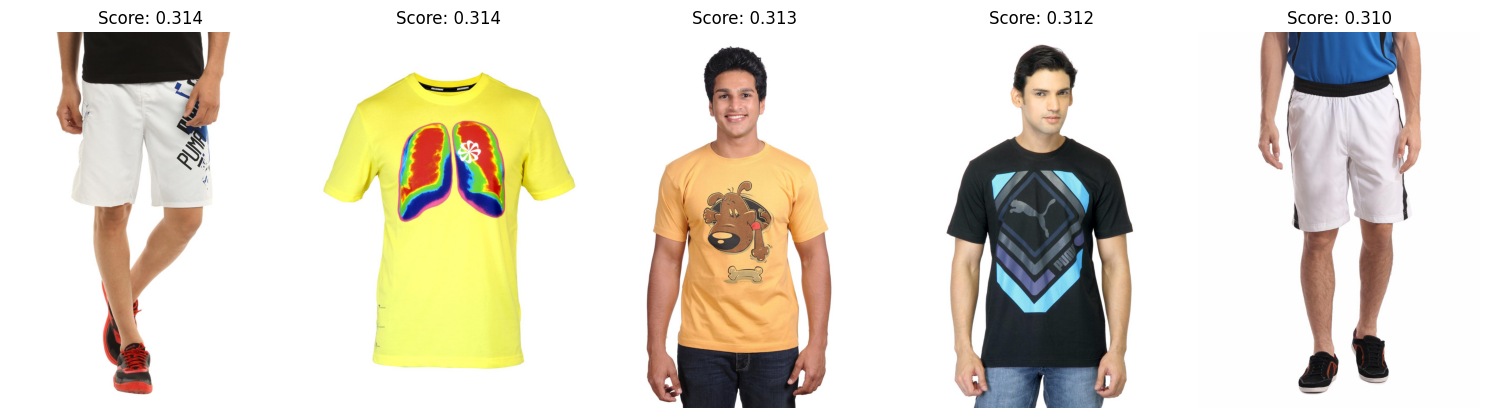

In [45]:
checkpoint_path = "checkpoints/clip_epoch_4.pth"
csv_file = "archive/data.csv"
image_dir = "archive/data"
embeddings_path = "precomputed_embeddings.pth"

test_queries = [
    "red skirt",
    "blue sunglasses", 
    "mickey mouse"
]

# Инициализация
search_system = initialize_search_system(
    checkpoint_path=checkpoint_path,
    csv_file=csv_file,
    image_dir=image_dir,
    embeddings_save_path=embeddings_path
)

for query in test_queries:
    print(f"\nЗапрос: '{query}'")
    
    # Поиск
    results = search_system.search_items(query, top_k=5)
    
    # Результаты
    for i, result in enumerate(results[:5], 1):
        print(f"{i}. {result['description']} (score: {result['similarity_score']:.3f})")
    
    if query in ["red skirt", "blue sunglasses", "mickey mouse"]:
        search_system.display_search_results(results[:5])